In [3]:
from io import BytesIO
from zipfile import ZipFile
import urllib.request
import requests
import pandas as pd
import numpy as np
import re
import string
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pylab as pl

In [4]:
original_data = []

url = urllib.request.urlopen("http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip")

with ZipFile(BytesIO(url.read())) as my_zip_file:
    for contained_file in my_zip_file.namelist():
        # with open(("unzipped_and_read_" + contained_file + ".file"), "wb") as output:
        for line in my_zip_file.open(contained_file).readlines():
            original_data.append(line)
            # output.write(line)

In [5]:
modified_data = original_data[4:]

for i in range(len(modified_data)):
    modified_data[i] = modified_data[i].decode('utf-8')
    modified_data[i] = modified_data[i].replace(' ', '')
    modified_data[i] = modified_data[i].replace('\r\n', '')

In [6]:
modified_data[0] = 'Date' + modified_data[0]
data_for_df = []

for i in modified_data:
    x = i.split(',')
    data_for_df.append(x)

In [7]:
df = pd.DataFrame(data_for_df[1:], columns=data_for_df[0])

In [8]:
df.drop(df.tail(2).index, 
        inplace = True)

df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

df.set_index('Date', inplace=True)

df = df.astype(float)
df = df / 100

In [9]:
tickers = input("""What stocks are in your portfolio?\n
                Enter each ticker uppercase and seperated by one space\n
                Ex. AAPL MSFT FB\n
                ---> """)

In [10]:
dates = input("""Would you like to specify the dates for the Fama-French Calculation?\n
                Format is 'YYYY-MM-DD'\n
                EX. 2018-01-01 2019-01-01\n
                Enter 'N/A' to use defualt data range (last 3 years)\n
                ---> """)

In [11]:
dates = dates.split(' ')

In [12]:
full_stock_data = yf.download(tickers, start=dates[0], end=dates[1])

[*********************100%***********************]  9 of 9 completed


In [13]:
close_stock_data = full_stock_data['Adj Close']

close_stock_returns = close_stock_data.pct_change()

In [14]:
col_names = list(close_stock_data)
stock_weights = []

In [15]:
weights_q = input("""Is the portfolio equally weighted?\n
                Enter Y/N\n
                ---> """)
if weights_q == 'Y':
    x = 1 / stock_returns.shape[1]
    for i in range(stock_returns.shape[1]):
        stock_weights.append(x)
else:
    for i in col_names:
        weight = float(input(f"""Enter weight in decimal format:
                    {i} ---> """))
        stock_weights.append(weight)

In [16]:
weighted_close_stock_returns = close_stock_returns * stock_weights

In [17]:
weighted_close_stock_returns['port_returns'] = weighted_close_stock_returns.sum(axis=1)

In [18]:
FF_final_data = pd.merge(df,weighted_close_stock_returns['port_returns'],
                        how='inner',
                        left_index=True,
                        right_index=True)

In [19]:
FF_final_data['port_excess_ret'] = FF_final_data['port_returns'] - FF_final_data['RF']

In [20]:
FF_final_data.head(25)

,Mkt-RF,SMB,HML,RF,port_returns,port_excess_ret
Date,,,,,,
2016-06-01,0.0020,0.0065,-0.0023,0.00001,0.000000,-0.000010
2016-06-02,0.0035,0.0031,-0.0058,0.00001,0.000806,0.000796
2016-06-03,-0.0038,-0.0014,-0.0012,0.00001,-0.010241,-0.010251
2016-06-06,0.0060,0.0067,0.0034,0.00001,0.008121,0.008111
2016-06-07,0.0012,0.0019,0.0010,0.00001,-0.000444,-0.000454
2016-06-08,0.0037,0.0044,-0.0008,0.00001,0.001031,0.001021
2016-06-09,-0.0027,-0.0039,-0.0024,0.00001,-0.000440,-0.000450
2016-06-10,-0.0105,-0.0034,-0.0018,0.00001,-0.017228,-0.017238
2016-06-13,-0.0084,-0.0036,0.0010,0.00001,-0.013570,-0.013580


                            OLS Regression Results                            
Dep. Variable:        port_excess_ret   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     2015.
Date:                Mon, 18 Jan 2021   Prob (F-statistic):          4.44e-215
Time:                        11:34:07   Log-Likelihood:                 2965.4
No. Observations:                 755   AIC:                            -5927.
Df Residuals:                     753   BIC:                            -5918.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.678e-05      0.000      0.269      0.7

Text(0.5,1,'CAPM Regression Graph')

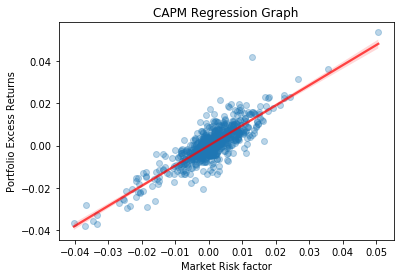

In [21]:
#CAPM Model Estimation

X = FF_final_data['Mkt-RF']
Y = FF_final_data['port_excess_ret']
X = sm.add_constant(X)
CAPM = sm.OLS(Y, X).fit()
predictions = CAPM.predict(X) 

print_model = CAPM.summary()
print(print_model)

graph = sns.regplot(x=FF_final_data["Mkt-RF"], y=FF_final_data["port_excess_ret"], data=FF_final_data,
           scatter_kws={'alpha':0.3}, line_kws={'color':'red', 'alpha':0.7}, truncate=True)
graph.set_xticks(pl.frange(round(FF_final_data["Mkt-RF"].min(), 2), round(FF_final_data["Mkt-RF"].max(), 2), 0.01))
graph.set_xlabel('Market Risk factor')
graph.set_ylabel('Portfolio Excess Returns')
graph.set_title('CAPM Regression Graph')

                            OLS Regression Results                            
Dep. Variable:        port_excess_ret   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     674.6
Date:                Mon, 18 Jan 2021   Prob (F-statistic):          1.37e-212
Time:                        11:34:09   Log-Likelihood:                 2967.3
No. Observations:                 755   AIC:                            -5927.
Df Residuals:                     751   BIC:                            -5908.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        5.57e-05      0.000      0.321      0.7

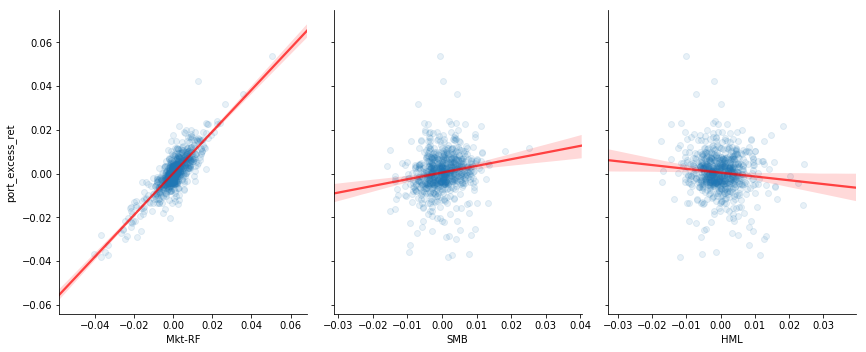

In [22]:
#Fama-French 3-Factor Model Estimation
X_FF = FF_final_data[['Mkt-RF', 'SMB', 'HML']]
Y_FF = FF_final_data['port_excess_ret']
X_FF = sm.add_constant(X_FF)
Fama_French_Model = sm.OLS(Y_FF, X_FF).fit()
predictions = Fama_French_Model.predict(X_FF) 

print_model = Fama_French_Model.summary()
print(print_model)

graph2 = sns.pairplot(FF_final_data, x_vars=["Mkt-RF", "SMB", "HML"], y_vars=["port_excess_ret"],
             height=5, aspect=.8, kind="reg", plot_kws={'line_kws':{'color':'red', 'alpha':0.7}, 'scatter_kws': {'alpha': 0.1}})

In [23]:
"""Uncomment out the code below to export the data to an excel file
    The file will be saved in your current working directory"""

#FF_final_data.to_excel('FFModel.xlsx')

'Uncomment out the code below to export the data to an excel file\n    The file will be saved in your current working directory'